## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import joblib

## DATA UNDERSTANDING

### 1. Load Dataset

> make relative path for those dataset

In [ ]:
tourism_with_id = pd.read_csv('data/tourism_with_id.csv')
tourism_rating = pd.read_csv('data/tourism_rating.csv')

View tourism_with_id table

In [ ]:
tourism_with_id.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,"4,6",15.0,"{'lat': -6.1753924, 'lng': 106.8271528}","-6,1753924","106,8271528"
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,"4,6",90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}","-6,1376448","106,8171245"
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,"4,6",360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}","-6,1253124","106,8335377"
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,"4,5",NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}","-6,3024459","106,8951559"
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,"4,5",60.0,"{'lat': -6.12419, 'lng': 106.839134}","-6,12419","106,839134"


View tourism_rating table

In [ ]:
tourism_rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,"3,00"
1,1,344,"2,00"
2,1,5,"5,00"
3,1,373,"3,00"
4,1,101,"4,00"


## DATA PRE-PROCESSING

### 1. Change The Data Type

There are some corrections on the data type in some tables. In the tourism_with_id table, we need to change Rating, Lat and Long column data type from object to float64.

In [ ]:
tourism_with_id['Rating'] = tourism_with_id['Rating'].str.replace(',', '.').astype(float)
tourism_with_id['Lat'] = tourism_with_id['Lat'].str.replace(',', '.').astype(float)
tourism_with_id['Long'] = tourism_with_id['Long'].str.replace(',', '.').astype(float)
tourism_with_id.dtypes

Place_Id          int64
Place_Name       object
Description      object
Category         object
City             object
 Price            int64
Rating          float64
Time_Minutes    float64
Coordinate       object
Lat             float64
Long            float64
dtype: object

Check tourism_with_id table's data types

In [ ]:
tourism_with_id.dtypes

Place_Id          int64
Place_Name       object
Description      object
Category         object
City             object
 Price            int64
Rating          float64
Time_Minutes    float64
Coordinate       object
Lat             float64
Long            float64
dtype: object

Check tourism_rating table's data types

In [ ]:
tourism_rating.dtypes

User_Id           int64
Place_Id          int64
Place_Ratings    object
dtype: object

Check each table's information that includes number of columns, column labels, column data types, memory usage, range index, and the number of cells in each column (non-null values).

In [ ]:
tourism_with_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      535 non-null    int64  
 1   Place_Name    535 non-null    object 
 2   Description   535 non-null    object 
 3   Category      535 non-null    object 
 4   City          535 non-null    object 
 5    Price        535 non-null    int64  
 6   Rating        535 non-null    float64
 7   Time_Minutes  204 non-null    float64
 8   Coordinate    535 non-null    object 
 9   Lat           535 non-null    float64
 10  Long          535 non-null    float64
dtypes: float64(4), int64(2), object(5)
memory usage: 46.1+ KB


In [ ]:
tourism_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12360 entries, 0 to 12359
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_Id        12360 non-null  int64 
 1   Place_Id       12360 non-null  int64 
 2   Place_Ratings  12360 non-null  object
dtypes: int64(2), object(1)
memory usage: 289.8+ KB


### 2. Check Data Duplication

Check if there's any data duplication in the row of the tables

In [ ]:
tourism_rating.describe()

,User_Id,Place_Id
count,12360.000000,12360.000000
mean,151.364401,270.552104
std,86.217019,155.138238
min,1.000000,1.000000
25%,77.000000,137.000000
50%,151.000000,271.000000
75%,226.000000,406.000000
max,300.000000,535.000000


In [ ]:
duplicate_tourism_rating = tourism_rating[tourism_rating.duplicated()]
duplicate_tourism_with_id = tourism_with_id[tourism_with_id.duplicated()]

duplicate_tourism_rating, duplicate_tourism_with_id

(       User_Id  Place_Id Place_Ratings
 34           1       328          2,00
 155          5       321          3,00
 171          5       301          2,00
 194          6        64          5,00
 219          7       213          3,00
 ...        ...       ...           ...
 11894      289       485          1,00
 11963      291        91          3,00
 11971      291       431          4,00
 12130      295       403          1,00
 12180      296       177          4,00
 
 [105 rows x 3 columns],
 Empty DataFrame
 Columns: [Place_Id, Place_Name, Description, Category, City,  Price, Rating, Time_Minutes, Coordinate, Lat, Long]
 Index: [])

The duplicate check results are as follows:
- `tourism_rating` has 79 duplicate rows.

In [ ]:
tourism_rating = tourism_rating.drop_duplicates()
tourism_rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12255 entries, 0 to 12359
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_Id        12255 non-null  int64 
 1   Place_Id       12255 non-null  int64 
 2   Place_Ratings  12255 non-null  object
dtypes: int64(2), object(1)
memory usage: 383.0+ KB


Print number of unique data

In [ ]:
print('Jumlah tempat wisata: ', len(tourism_with_id.Place_Id.unique()))
print('Jumlah user: ', len(tourism_rating.User_Id.unique()))

Jumlah tempat wisata:  535
Jumlah user:  300


### 3. Drop Unnecessary Column

Dropn the unnecessary column that we don't need to use onward, such as Description, City, Price, Rating, Time_Minutes, Coordinate, Lat, and Long

In [ ]:
tourism_with_id.rename(columns={' Price': 'Price'}, inplace=True)
tourism_with_id = tourism_with_id.drop(['Description', 'Price', 'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long'], axis = 1)
tourism_with_id.head()  

,Place_Id,Place_Name,Category,City
0,1,Monumen Nasional,Budaya,Jakarta
1,2,Kota Tua,Budaya,Jakarta
2,3,Dunia Fantasi,Taman Hiburan,Jakarta
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan,Jakarta
4,5,Atlantis Water Adventure,Taman Hiburan,Jakarta


### 4. Make New DataFrame

Merge the previous remaining column in tourism_rating table with Place_Id and Category columns from tourism_with_id to make tourism_new dataframe

In [ ]:
tourism_new = pd.merge(tourism_rating, tourism_with_id[['Place_Id', 'Category']], on = 'Place_Id', how = 'left')
tourism_new

,User_Id,Place_Id,Place_Ratings,Category
0,1,179,"3,00",Budaya
1,1,344,"2,00",Bahari
2,1,5,"5,00",Taman Hiburan
3,1,373,"3,00",Budaya
4,1,101,"4,00",Budaya
...,...,...,...,...
12250,300,534,"2,00",Taman Hiburan
12251,300,64,"4,00",Budaya
12252,300,311,"3,00",Cagar Alam
12253,300,279,"4,00",Tempat Ibadah


Merge the previous dataframe with tourism_with_id's Place_Id and Place_Name columns to make tourism_all dataframe

In [ ]:
tourism_all = pd.merge(tourism_new, tourism_with_id[['Place_Id', 'Place_Name', 'City']], on = 'Place_Id', how = 'left')
tourism_all

,User_Id,Place_Id,Place_Ratings,Category,Place_Name,City
0,1,179,"3,00",Budaya,Candi Ratu Boko,Yogyakarta
1,1,344,"2,00",Bahari,Pantai Marina,Semarang
2,1,5,"5,00",Taman Hiburan,Atlantis Water Adventure,Jakarta
3,1,373,"3,00",Budaya,Museum Kereta Ambarawa,Semarang
4,1,101,"4,00",Budaya,Kampung Wisata Sosro Menduran,Yogyakarta
...,...,...,...,...,...,...
12250,300,534,"2,00",Taman Hiburan,Joglo Park,Mojokerto
12251,300,64,"4,00",Budaya,Museum Sasmita Loka Ahmad Yani,Jakarta
12252,300,311,"3,00",Cagar Alam,The Lodge Maribaya,Bandung
12253,300,279,"4,00",Tempat Ibadah,Masjid Agung Trans Studio Bandung,Bandung


### 4. Check the Finalized DataFrame

In [ ]:
tourism_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12255 entries, 0 to 12254
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_Id        12255 non-null  int64 
 1   Place_Id       12255 non-null  int64 
 2   Place_Ratings  12255 non-null  object
 3   Category       12255 non-null  object
 4   Place_Name     12255 non-null  object
 5   City           12255 non-null  object
dtypes: int64(2), object(4)
memory usage: 574.6+ KB


### 5. Check the Null-value

In [ ]:
tourism_all.isnull().sum()

User_Id          0
Place_Id         0
Place_Ratings    0
Category         0
Place_Name       0
City             0
dtype: int64

## DATA VISUALIZATION

### 1. Diagram of Number of Tourism Places For Each City

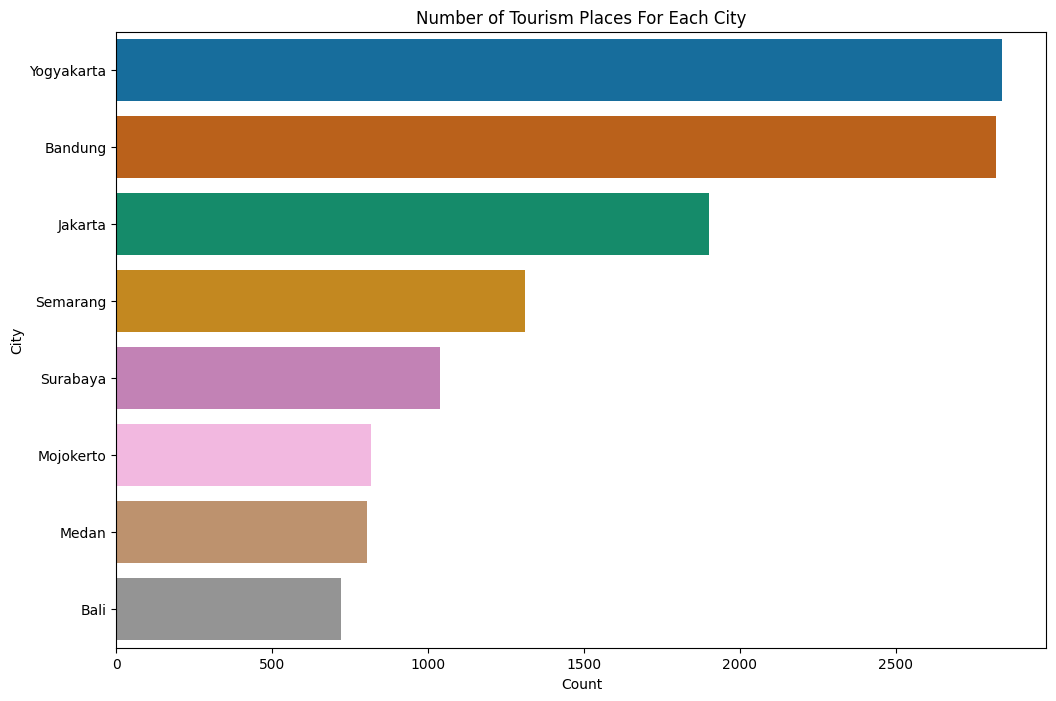

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(data=tourism_all, y='City', order=tourism_all['City'].value_counts().index, hue='City', dodge=False, palette='colorblind', legend=False)
plt.title('Number of Tourism Places For Each City')
plt.xlabel('Count')
plt.ylabel('City')
plt.show()

### 2. Diagram of Number of Tourism Places For Each Category

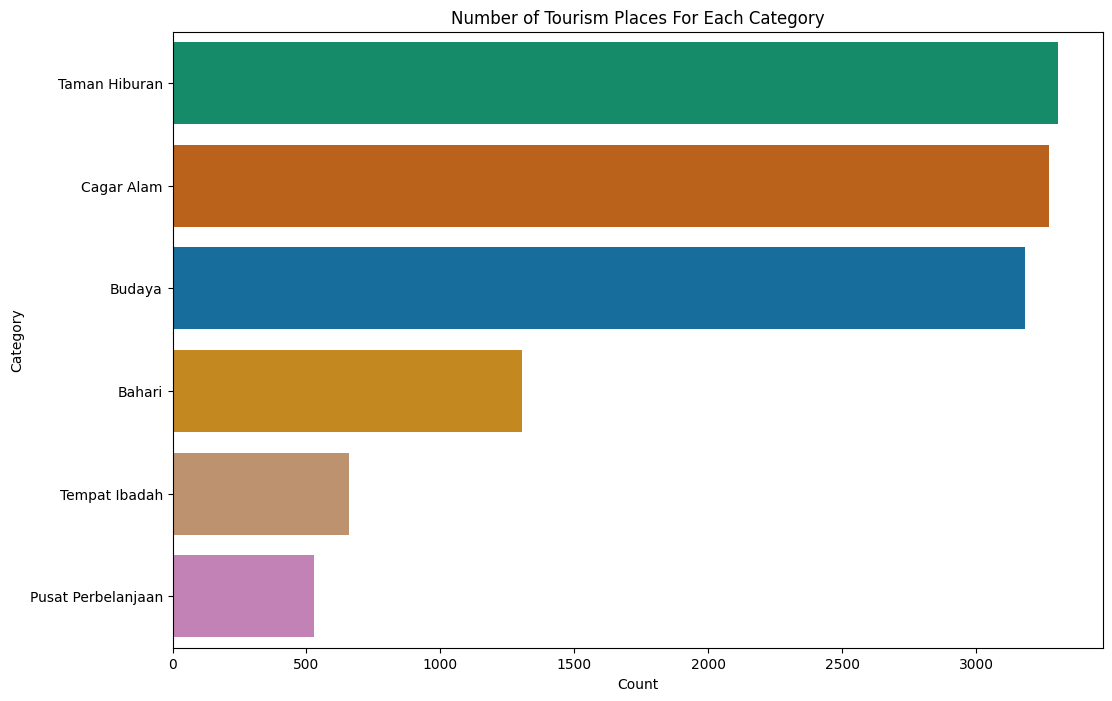

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(data=tourism_all, y='Category', order=tourism_all['Category'].value_counts().index, hue='Category', dodge=False, palette='colorblind', legend=False)
plt.title('Number of Tourism Places For Each Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

### 3. Diagram of Number of Place Ratings

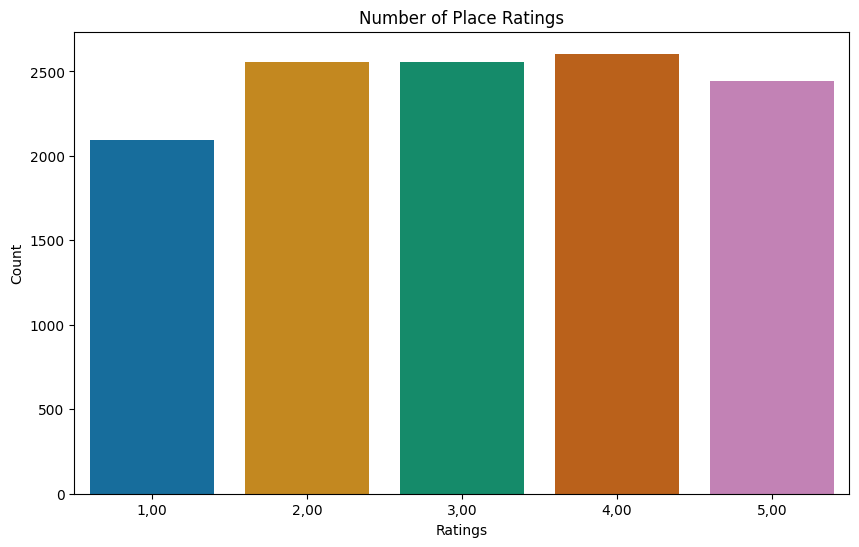

In [ ]:
rating_counts = tourism_all['Place_Ratings'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, hue=rating_counts.index, dodge=False, palette='colorblind', legend=False)
plt.title('Number of Place Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

### 4. Diagram of Most Popular Tourism Places Based on Number of Ratings

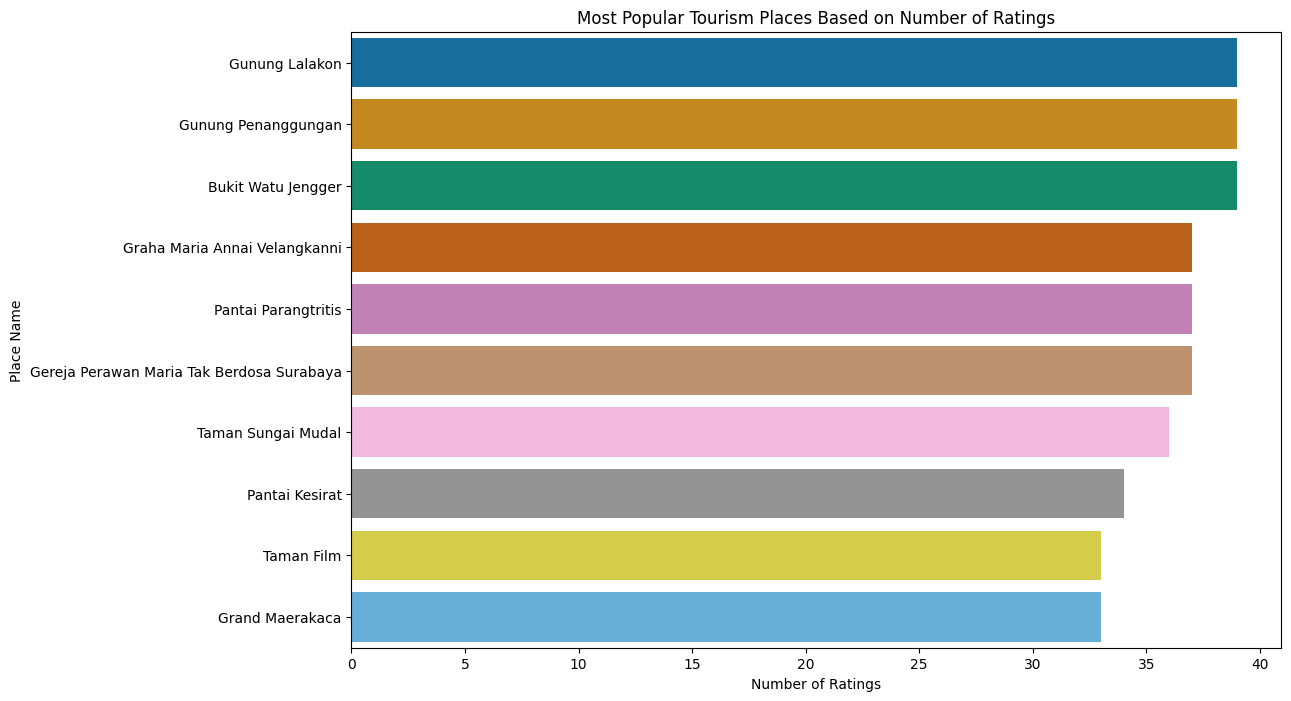

In [ ]:
place_counts = tourism_all['Place_Name'].value_counts().head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=place_counts.values, y=place_counts.index, hue=place_counts.index, dodge=False, palette='colorblind', legend=False)
plt.title('Most Popular Tourism Places Based on Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Place Name')
plt.show()

## DATA PREPARATION

In [ ]:
len(tourism_all.Place_Id.unique())

535

In [ ]:
tourism_all['Category'].unique()

array(['Budaya', 'Bahari', 'Taman Hiburan', 'Cagar Alam',
       'Pusat Perbelanjaan', 'Tempat Ibadah'], dtype=object)

In [ ]:
#sort by Place_Id
data_prep = tourism_all
data_prep.sort_values('Place_Id')

,User_Id,Place_Id,Place_Ratings,Category,Place_Name,City
6560,162,1,"5,00",Budaya,Monumen Nasional,Jakarta
4721,118,1,"4,00",Budaya,Monumen Nasional,Jakarta
3415,86,1,"4,00",Budaya,Monumen Nasional,Jakarta
1470,38,1,"2,00",Budaya,Monumen Nasional,Jakarta
4169,105,1,"5,00",Budaya,Monumen Nasional,Jakarta
...,...,...,...,...,...,...
341,10,535,"3,00",Budaya,Museum Majapahit,Mojokerto
3776,95,535,"3,00",Budaya,Museum Majapahit,Mojokerto
4402,110,535,"4,00",Budaya,Museum Majapahit,Mojokerto
1925,49,535,"5,00",Budaya,Museum Majapahit,Mojokerto


In [ ]:
data_prep = data_prep.drop_duplicates('Place_Id')
data_prep

,User_Id,Place_Id,Place_Ratings,Category,Place_Name,City
0,1,179,"3,00",Budaya,Candi Ratu Boko,Yogyakarta
1,1,344,"2,00",Bahari,Pantai Marina,Semarang
2,1,5,"5,00",Taman Hiburan,Atlantis Water Adventure,Jakarta
3,1,373,"3,00",Budaya,Museum Kereta Ambarawa,Semarang
4,1,101,"4,00",Budaya,Kampung Wisata Sosro Menduran,Yogyakarta
...,...,...,...,...,...,...
2939,74,350,"4,00",Bahari,Pantai Cipta,Semarang
2994,75,10,"2,00",Bahari,Pulau Tidung,Jakarta
3093,78,7,"4,00",Cagar Alam,Kebun Binatang Ragunan,Jakarta
3107,78,520,"3,00",Cagar Alam,Sumber Kecumbung,Mojokerto


In [ ]:
place_id = data_prep['Place_Id'].tolist()
place_category = data_prep['Category'].tolist()
place_name = data_prep['Place_Name'].tolist()
place_city = data_prep['City'].tolist()

print(len(place_id))
print(len(place_category))
print(len(place_name))
print(len(place_city))

535
535
535
535


In [ ]:
tourism_recs = pd.DataFrame({
    'id' : place_id,
    'place_category' : place_category,
    'place_name' : place_name,
    #'city': place_city # include the city information
})

tourism_recs

,id,place_category,place_name
0,179,Budaya,Candi Ratu Boko
1,344,Bahari,Pantai Marina
2,5,Taman Hiburan,Atlantis Water Adventure
3,373,Budaya,Museum Kereta Ambarawa
4,101,Budaya,Kampung Wisata Sosro Menduran
...,...,...,...
530,350,Bahari,Pantai Cipta
531,10,Bahari,Pulau Tidung
532,7,Cagar Alam,Kebun Binatang Ragunan
533,520,Cagar Alam,Sumber Kecumbung


## MODEL | CONTENT-BASED FILTERING

In [ ]:
content_based = tourism_recs
tf = TfidfVectorizer()
tf.fit(content_based['place_name'])
tf.get_feature_names_out()

array(['3d', '45', '825', 'abang', 'abdullah', 'ade', 'adhyatma',
       'adventure', 'africa', 'afrika', 'agro', 'agrowisata', 'agung',
       'ahmad', 'air', 'aji', 'akbar', 'al', 'alam', 'alive', 'alun',
       'amazing', 'ambarawa', 'ancol', 'and', 'anggrek', 'angke',
       'angklung', 'anjasmoro', 'annai', 'anom', 'anteng', 'api',
       'aquarium', 'ardilla', 'argo', 'art', 'artha', 'asam', 'aseupan',
       'asia', 'asri', 'atlantis', 'ayodya', 'babakan', 'badak', 'baduga',
       'bahari', 'bajang', 'balai', 'bali', 'bambu', 'banaran', 'bandros',
       'bandung', 'bangsal', 'bangunrejo', 'bank', 'bantal', 'banteng',
       'barat', 'barisan', 'barli', 'barn', 'baron', 'baru', 'baruna',
       'barunawati', 'basoeki', 'batik', 'batu', 'batununggal', 'batur',
       'bay', 'bbws', 'bby', 'beachwalk', 'becici', 'begonia', 'belanda',
       'belawan', 'bendung', 'bening', 'benoa', 'bentara', 'benteng',
       'berastagi', 'beratan', 'berdosa', 'beringharjo', 'bernah',
       'bes

In [ ]:
tfdif_matrix = tf.fit_transform(content_based['place_name'])
tfdif_matrix.shape

(535, 853)

In [ ]:
tfdif_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
pd.DataFrame(
    tfdif_matrix.todense(),
    columns = tf.get_feature_names_out(),
    index = content_based.place_category  
).sample(22, axis = 1).sample(10, axis = 0)

,coban,keputran,kilometer,dlundung,palayangan,parangkusumo,sanghyang,upside,medan,drini,...,hu,klenteng,bentara,peta,baru,chingu,tilu,dago,in,ardilla
place_category,,,,,,,,,,,,,,,,,,,,,
Taman Hiburan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Cagar Alam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Taman Hiburan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Bahari,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Taman Hiburan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.684322,0.0,0.0
Bahari,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Taman Hiburan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Budaya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Cagar Alam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
cosine_sim = cosine_similarity(tfdif_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim, index = content_based['place_name'], columns = content_based['place_name'])
print('Shape : ', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis = 1).sample(10, axis = 0)

Shape :  (535, 535)


place_name,Beachwalk Shopping Center,Waterboom PIK (Pantai Indah Kapuk),Kampoeng Kopi Banaran,Pantai Drini,Blue Lagoon Jogja
place_name,,,,,
La Kana Chapel,0.0,0.0,0.0,0.0,0.000000
Umbul Sidomukti,0.0,0.0,0.0,0.0,0.000000
Candi Gedong Songo,0.0,0.0,0.0,0.0,0.000000
Kampung Wisata Sosro Menduran,0.0,0.0,0.0,0.0,0.000000
Hutan Bambu Keputih,0.0,0.0,0.0,0.0,0.000000
Sunrise Point Cukul,0.0,0.0,0.0,0.0,0.000000
Jogja Bay Pirates Adventure Waterpark,0.0,0.0,0.0,0.0,0.176466
Duyung Trawas Hill,0.0,0.0,0.0,0.0,0.000000
Air Terjun Sipiso-Piso,0.0,0.0,0.0,0.0,0.000000


In [ ]:
def tourism_recommendations(nama_tempat, similarity_data = cosine_sim_df, items = content_based[['place_name', 'place_category']], k = 5) :
  index = similarity_data.loc[:, nama_tempat].to_numpy().argpartition(
      range(-1, -k, -1)
  )

  closest = similarity_data.columns[index[-1:-(k+2):-1]]
  closest = closest.drop(nama_tempat, errors = 'ignore')

  return pd.DataFrame(closest).merge(items).head(k)

Save content based filtering model

In [ ]:
joblib.dump(tf, 'tfidf_vectorizer.pkl')
joblib.dump(tfdif_matrix, 'tfidf_matrix.pkl')
joblib.dump(cosine_sim, 'cosine_similarity.pkl')

['cosine_similarity.pkl']

The content-based filtering model has been saved successfully. The following files are available:
- `cosine_similarity.pkl`
- `tfidf_matrix.pkl`
- `tfidf_vectorizer.pkl`

In [ ]:
content_based[content_based.place_name.eq('Pantai Kuta')]

,id,place_category,place_name
201,438,Bahari,Pantai Kuta


In [ ]:
tourism_recommendations('Pantai Kuta')

,place_name,place_category
0,Pantai Mangrove,Bahari
1,Pantai Ancol,Bahari
2,Pantai Marina,Bahari
3,Pantai Greweng,Bahari
4,Pantai Ngobaran,Bahari


## MODEL | COLLABORATIVE FILTERING 

In [ ]:
import tensorflow as tf

# Define the RecommenderNet class
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_places, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_places = num_places
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-5)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.places_embedding = layers.Embedding(
            num_places,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-5)
        )
        self.places_bias = layers.Embedding(num_places, 1)
        self.dropout = layers.Dropout(0.3)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        places_vector = self.places_embedding(inputs[:, 1])
        places_bias = self.places_bias(inputs[:, 1])

        user_vector = self.dropout(user_vector)
        places_vector = self.dropout(places_vector)

        dot_user_places = tf.tensordot(user_vector, places_vector, 2)

        x = dot_user_places + user_bias + places_bias

        return tf.nn.sigmoid(x)

In [ ]:
# Prepare the data
collaborative = tourism_all

user_ids = collaborative['User_Id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

place_ids = collaborative['Place_Id'].unique().tolist()
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

collaborative['user'] = collaborative['User_Id'].map(user_to_user_encoded)
collaborative['place'] = collaborative['Place_Id'].map(place_to_place_encoded)

num_users = len(user_to_user_encoded)
num_places = len(place_encoded_to_place)

# Replace commas with dots and convert to float
# Prepare the data
collaborative = tourism_all

user_ids = collaborative['User_Id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

place_ids = collaborative['Place_Id'].unique().tolist()
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

collaborative['user'] = collaborative['User_Id'].map(user_to_user_encoded)
collaborative['place'] = collaborative['Place_Id'].map(place_to_place_encoded)

num_users = len(user_to_user_encoded)
num_places = len(place_encoded_to_place)

collaborative['Place_Ratings'] = collaborative['Place_Ratings'].str.replace(',', '.').astype(np.float32)

min_rating = min(collaborative['Place_Ratings'])
max_rating = max(collaborative['Place_Ratings'])

min_rating = min(collaborative['Place_Ratings'])
max_rating = max(collaborative['Place_Ratings'])

In [ ]:
x = collaborative[['user', 'place']].values
y = collaborative['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.8 * collaborative.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [ ]:
# Create and compile the model
model = RecommenderNet(num_users, num_places, 30)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
hist = model.fit(x=x_train, y=y_train, batch_size=8, epochs=100, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/100
1226/1226 [==============================] - 5s 3ms/step - loss: 0.6932 - root_mean_squared_error: 0.3412 - val_loss: 0.6945 - val_root_mean_squared_error: 0.3581
Epoch 2/100
1226/1226 [==============================] - 4s 3ms/step - loss: 0.6878 - root_mean_squared_error: 0.3371 - val_loss: 0.6947 - val_root_mean_squared_error: 0.3582
Epoch 3/100
1226/1226 [==============================] - 4s 3ms/step - loss: 0.6831 - root_mean_squared_error: 0.3335 - val_loss: 0.6951 - val_root_mean_squared_error: 0.3583
Epoch 4/100
1226/1226 [==============================] - 4s 3ms/step - loss: 0.6794 - root_mean_squared_error: 0.3306 - val_loss: 0.6957 - val_root_mean_squared_error: 0.3586
Epoch 5/100
1226/1226 [==============================] - 4s 3ms/step - loss: 0.6766 - root_mean_squared_error: 0.3284 - val_loss: 0.6962 - val_root_mean_squared_error: 0.3588
Epoch 6/100
1226/1226 [==============================] - 4s 3ms/step - loss: 0.6730 - root_mean_squared_error: 0.3256 - val_l

In [ ]:
# Save the collaborative filtering model in TensorFlow SavedModel format
model.save('collaborative_model', save_format='tf')

INFO:tensorflow:Assets written to: collaborative_model/assets
INFO:tensorflow:Assets written to: collaborative_model/assets


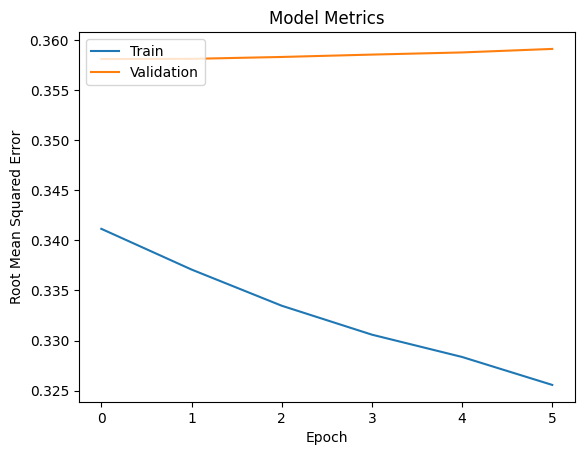

In [ ]:
# Plot the training and validation metrics
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

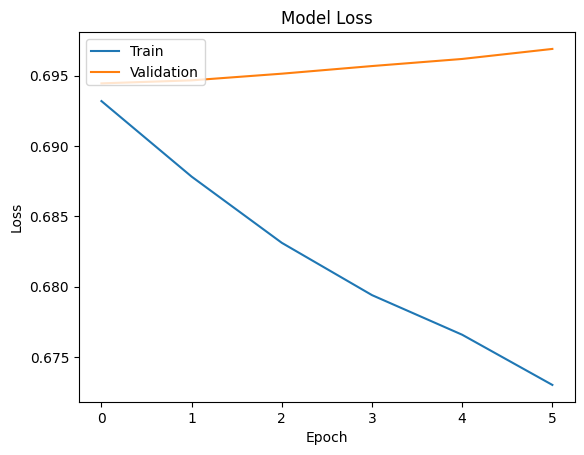

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The plot shows the training and validation loss over epochs. The validation loss does not show a significant increase while the training loss decreases, indicating that the model is not encountering overfitting. The early stopping mechanism has likely prevented overfitting by stopping the training process when the validation loss stopped improving.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on validation set
val_predictions = model.predict(x_val)

# Calculate MAE, MSE, and R²
mae = mean_absolute_error(y_val, val_predictions)
mse = mean_squared_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)

mae, mse, r2

77/77 [==============================] - 0s 1ms/step


(0.3085142362852186, 0.1282522895833278, -0.002726144261131047)

The metrics we obtained are:

- Mean Absolute Error (MAE): 0.3081
- Mean Squared Error (MSE): 0.1278
- R-squared (R²): 0.0004

In [ ]:
# Implementation of cold start recommendations

def cold_start_recommendations(tourism_all, top_n=10):
    # Get the most popular places based on the number of ratings
    popular_places = tourism_all['Place_Name'].value_counts().head(top_n).index.tolist()
    
    # Get the details of the most popular places
    recommendations = tourism_all[tourism_all['Place_Name'].isin(popular_places)].drop_duplicates('Place_Name')
    
    return recommendations[['Place_Id', 'Place_Name', 'Category', 'City']]

# Example usage
cold_start_recommendations(tourism_all)

,Place_Id,Place_Name,Category,City
11,208,Taman Sungai Mudal,Cagar Alam,Yogyakarta
15,336,Grand Maerakaca,Taman Hiburan,Semarang
48,437,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,Surabaya
49,483,Graha Maria Annai Velangkanni,Tempat Ibadah,Medan
134,294,Taman Film,Budaya,Bandung
195,298,Gunung Lalakon,Cagar Alam,Bandung
196,509,Gunung Penanggungan,Cagar Alam,Mojokerto
197,526,Bukit Watu Jengger,Cagar Alam,Mojokerto
442,177,Pantai Parangtritis,Bahari,Yogyakarta
554,201,Pantai Kesirat,Bahari,Yogyakarta


In [ ]:
# Create a function to get recommendations for a user based on the collaborative filtering model

def get_recommendations(user_id, model, collaborative, place_encoded_to_place, place_to_place_encoded, tourism_with_id, top_n=10):
    # Get the user's encoded ID
    user_encoded = user_to_user_encoded.get(user_id)
    if user_encoded is None:
        return f"User ID {user_id} not found."
    
    # Get the places the user has already rated
    user_rated_places = collaborative[collaborative['user'] == user_encoded]
    user_rated_place_ids = user_rated_places['place'].tolist()
    
    # Predict ratings for all places
    all_place_ids = np.array(list(place_encoded_to_place.keys()))
    user_place_array = np.hstack(([[user_encoded]] * len(all_place_ids), all_place_ids.reshape(-1, 1)))
    predicted_ratings = model.predict(user_place_array).flatten()
    
    # Filter out places the user has already rated
    unrated_place_indices = [i for i in range(len(all_place_ids)) if all_place_ids[i] not in user_rated_place_ids]
    unrated_place_ids = all_place_ids[unrated_place_indices]
    unrated_place_ratings = predicted_ratings[unrated_place_indices]
    
    # Get the top N recommendations
    top_indices = np.argsort(unrated_place_ratings)[-top_n:][::-1]
    top_place_ids = [place_encoded_to_place[i] for i in unrated_place_ids[top_indices]]
    
    # Get the place details
    recommendations = tourism_with_id[tourism_with_id['Place_Id'].isin(top_place_ids)]
    
    return recommendations

# Example usage for user ID 301
user_id = 301
recommendations = get_recommendations(user_id, model, collaborative, place_encoded_to_place, place_to_place_encoded, tourism_with_id)
recommendations

'User ID 301 not found.'

Save a TensorFlow model in the `.tflite` format

In [ ]:
model_path = 'collaborative_model'
model = tf.keras.models.load_model(model_path)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
tflite_model_path = 'collaborative_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpl0w8dis0/assets
INFO:tensorflow:Assets written to: /tmp/tmpl0w8dis0/assets
2024-06-19 15:35:23.554917: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-06-19 15:35:23.554974: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-06-19 15:35:23.555781: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpl0w8dis0
2024-06-19 15:35:23.558140: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-06-19 15:35:23.558178: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpl0w8dis0
2024-06-19 15:35:23.563971: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-06-19 15:35:23.565198: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-06-19 15:35:23.585919: I ten

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=efc5e3d2-e851-4218-9294-43a53c74b6bf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>